# Model

Here we analyze the processed z-scores of .CEL files  

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing

<br>

### Logistic regression of Z-score in age groups


### Devide the samples in age groups

Collect all the file names by doing
```bash
$ls > 'filenames.txt'
```

Text(0.5, 1.0, 'Distribution of Male samples')

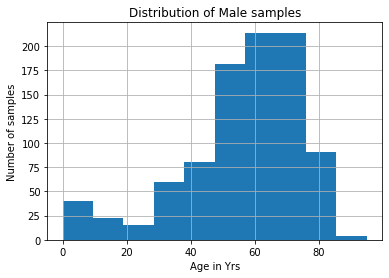

In [10]:
with open('./expr_files/filenames.txt', 'r') as f:
    lines = f.read()
    filenames = lines.split('\n')
    
expr_sam_ids = [f[:-4] for f in filenames]

df = pd.read_csv('age_sex_data.csv').drop('Unnamed: 0', axis = 1)
df = df[df.sample_id.isin(expr_sam_ids)].reset_index().drop('index', axis=1)
df.sex = df.sex.apply(lambda x: x.upper()[0])
df['age'] = (df.age_1+df.age_2)/2 

df[df.sex == 'M'].age.hist()
plt.xlabel('Age in Yrs')
plt.ylabel('Number of samples')
plt.title('Distribution of Male samples')

Text(0.5, 1.0, 'Distribution of Female samples')

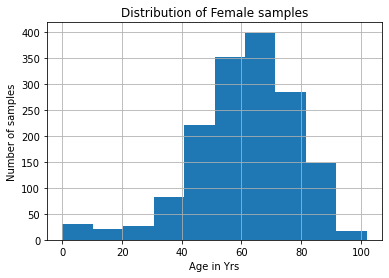

In [11]:
df[df.sex == 'F'].age.hist()
plt.xlabel('Age in Yrs')
plt.ylabel('Number of samples')
plt.title('Distribution of Female samples')

Text(0, 0.5, 'Number of samples')

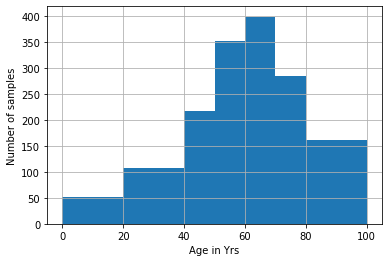

In [9]:
# We devide the age groups in such a way that every age group has atleast 50 samples

age_groups = [0,20,40,50,60,70,80,100]
df[df.sex == 'F'].age.hist(bins= age_groups)
plt.xlabel('Age in Yrs')
plt.ylabel('Number of samples')

In [ ]:
def get_age_stratified_df(age_ind):
    '''
    Collect the sample ids for the particular age group 
    and returns a dataframe corresponding to a particular age group.  
    '''
    with open('./expr_files/filenames.txt', 'r') as f:
        lines = f.read()
        filenames = lines.split('\n')
    expr_sam_ids = [f[:-4] for f in filenames]
    df = pd.read_csv('age_sex_data.csv').drop('Unnamed: 0', axis = 1)
    df = df[df.sample_id.isin(expr_sam_ids)].reset_index().drop('index', axis=1)
    df.sex = df.sex.apply(lambda x: x.upper()[0])
    df['age'] = (df.age_1+df.age_2)/2 
    dff = df[(df.age > age_groups[age_ind]) & (df.age < age_groups[age_ind+1])]
    df_list = [pd.read_csv('./expr_files/'+sample_id+'.csv') for sample_id in dff.sample_id]
    joined_df = reduce(lambda x, y: pd.merge(x, y, on = 'Unnamed: 0'), df_list)    
    
    return joined_df.rename(columns={'Unnamed: 0':'probe_id'})

### Logistic regression accuarcy as the bias score

With in each group we train a Logistic Regression model for each gene. How accuartely the LR model can predict sex of the sample from their expression z-score signifies how biased the gene is. Therefore, accuary score of the LR model acts as the the indicator of sex bias. The coeffcinet of the LR model indicates if the bias is towards Male or Female.

In [ ]:
def get_accuracy(probe_row_num):
    
    lr = LogisticRegression()
    X = np.array(jj_df.iloc[probe_row_num,1:]).reshape(-1,1)
    sns = [sn[:-7] for sn in jj_df.columns[1:]]
    y = df[df.sample_id.isin(sns)]['sex']
    y = np.array((y == 'F').apply(int))

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=1)

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    ac_score = accuracy_score(y_pred, y_test)
    if lr.coef_[0][0] < 0:
        ac_score = -ac_score
    else:
        pass
    
    return ac_score

## Fully parallelized computing of accuracies for each gene in each age_group

for age_ind in range(len(age_groups)-1):

    jj_df = get_age_stratified_df(age_ind)
    print(f'Reading files for age_group {age_ind} done')
    row_nums = range(len(jj_df))
    
    print('Starting accuracy calculation')
    num_processes = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(num_processes) ### number of processesor I want to use
    ac_scores = pool.map(get_accuracy, row_nums)
    accu_df = pd.DataFrame({'probe_id':list(jj_df.probe_id),'accuracy': ac_scores})
    
    print('Writing output to files')
    accu_df.to_csv('./sex_bias/age_group_'+str(age_ind)+'.csv', index = False)

<br><br>

Get the gene_ids and Gene symbols corresponding to the prob_ids of platform's CDF. Download 'full table' from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL570

<br>

In [ ]:
gpl_df = pd.read_csv('GPL570-55999.txt', sep='\t', header=16, low_memory=False)
gpl_df = gpl_df.rename(columns={'ID':'probe_id'})

accu_dfs= []
for age_ind in range(len(age_groups)-1):
    accuracy_df= pd.read_csv('./sex_bias/age_group_'+str(age_ind)+'.csv').rename(columns={'accuracy': 'age_group_'+str(age_ind)})    
    accu_dfs.append(accuracy_df)
accu_df = reduce(lambda x, y: pd.merge(x, y, on = 'probe_id'), accu_dfs)
accu_df_comb = accu_df.merge(gpl_df[['probe_id', 'Gene Symbol', 'ENTREZ_GENE_ID']])

<br>

### Find the chromosome loaction of the Genes

In [ ]:
def get_chromosome(gene_id):
    '''Gets the corresponding chromosome name given the Entrenz gene id from NCBI data base 
    '''    
    if  str(gene_id) != 'nan':
        try:
            url = 'https://www.ncbi.nlm.nih.gov/gene/'+str(gene_id).split(' /// ')[0]+'/'
            tab1 = pd.read_html(url)
            chrs = tab1[0]['Chr'][0]
        except:
            chrs = 'NA'
    else: 
        chrs = 'NA'
    return chrs

<br>
Filter the genes which has atleast 0.8 accuarcy in any age-group. Then collect the chromosome location for those genes

In [ ]:
accu_df_biased = accu_df_comb[(accu_df.drop('probe_id',axis=1).abs() > 0.8).any(axis=1)]

# Parallelize the chromosome collection

num_processes = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_processes)

chromosome = pool.map(get_chromosome, list(accu_df_biased.ENTREZ_GENE_ID))

accu_df_biased['Chromosome'] = chromosome

accu_df_biased.to_csv('./sex_bias/acuuracy_combined.csv', index= False)